In [1]:
import yaml
import os
import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt

### after you install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/tobit/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/tobit/bart-0.7.00/"
import bart

In [2]:
## Saves sens maps as a single .h5 file per slice

with open('./datasets/train_48_selfsup_slice.yaml', 'r') as stream:
    filenames = yaml.safe_load(stream)

In [3]:
filenames

[{'filename': 'file_brain_AXT2_207_2070586',
  'path': 'multicoil_train/file_brain_AXT2_207_2070586.h5',
  'predefined_mask': None,
  'slice': 0},
 {'filename': 'file_brain_AXT2_207_2070586',
  'path': 'multicoil_train/file_brain_AXT2_207_2070586.h5',
  'predefined_mask': None,
  'slice': 1},
 {'filename': 'file_brain_AXT2_207_2070586',
  'path': 'multicoil_train/file_brain_AXT2_207_2070586.h5',
  'predefined_mask': None,
  'slice': 2},
 {'filename': 'file_brain_AXT2_207_2070586',
  'path': 'multicoil_train/file_brain_AXT2_207_2070586.h5',
  'predefined_mask': None,
  'slice': 3},
 {'filename': 'file_brain_AXT2_207_2070586',
  'path': 'multicoil_train/file_brain_AXT2_207_2070586.h5',
  'predefined_mask': None,
  'slice': 4},
 {'filename': 'file_brain_AXT2_207_2070586',
  'path': 'multicoil_train/file_brain_AXT2_207_2070586.h5',
  'predefined_mask': None,
  'slice': 5},
 {'filename': 'file_brain_AXT2_207_2070586',
  'path': 'multicoil_train/file_brain_AXT2_207_2070586.h5',
  'predefined

In [4]:
def apply_center_mask(kspace,center_fraction):
    num_cols = kspace.shape[-1]

    #center_fraction = 0.08
    acceleration = 4

    # create the mask
    num_low_freqs = int(round(num_cols * center_fraction))
    #print(num_low_freqs)
    num_high_freqs = round(num_cols / acceleration) - num_low_freqs
    pad = (num_cols - num_low_freqs + 1) // 2

    all_freqs_indices = np.arange(num_cols)
    all_high_freqs_indices = np.hstack((all_freqs_indices[: pad],all_freqs_indices[pad + num_low_freqs :]))

    chosen_high_freqs_indices = np.random.choice(all_high_freqs_indices, size=num_high_freqs, replace=False, p=None)

    mask = np.zeros(num_cols)
    
    mask[pad : pad + num_low_freqs] = 1.0
    #mask[chosen_high_freqs_indices] = 1.0
    #print(mask)
    
    mask_shape = [1 for _ in kspace.shape]
    mask_shape[-1] = num_cols
    mask = mask.reshape(*mask_shape)

    masked_kspace = kspace*mask + 0.0
    return masked_kspace, num_low_freqs

In [5]:
save_path = './sens_maps/'
path_to_fastMRI = "/media/ssd1/fastMRIdata/brain/"

counter = 0
for file in filenames:
    
    ## Load kspace
    with h5py.File(path_to_fastMRI + file["path"], "r") as hf:
        kspace_slice = hf["kspace"][file["slice"]]
    
    center_fraction = 0.08

    counter+=1
    print(counter)

    ## Apply mask only on the 0.08 center fraction
    masked_kspace, num_low_freqs = apply_center_mask(kspace_slice,center_fraction)

    ## Compute sens map
    sens_maps = bart.bart(1, 'ecalib -d0 -m1', np.array([np.moveaxis(masked_kspace,0,2)]))
    sens_maps = np.moveaxis(sens_maps[0],2,0)   

    ## Save sens map
    sensmap_fname = file["filename"] + '_smaps_slice' + str(file["slice"]) + '.h5'
    with h5py.File(save_path + sensmap_fname, "w") as hf:
        hf.create_dataset('sens_maps', data=sens_maps)  

1
Done.
2
Done.
3
Done.
4
Done.
5
Done.
6
Done.
7
Done.
8
Done.
9
Done.
10
Done.
11
Done.
12
Done.
13
Done.
14
Done.
15
Done.
16
Done.
17
Done.
18
Done.
19
Done.
20
Done.
21
Done.
22
Done.
23
Done.
24
Done.
25
Done.
26
Done.
27
Done.
28
Done.
29
Done.
30
Done.
31
Done.
32
Done.
33
Done.
34
Done.
35
Done.
36
Done.
37
Done.
38
Done.
39
Done.
40
Done.
41
Done.
42
Done.
43
Done.
44
Done.
45
Done.
46
Done.
47
Done.
48
Done.


In [6]:
print(sens_maps.shape)

(20, 768, 396)


(-0.5, 395.5, 767.5, -0.5)

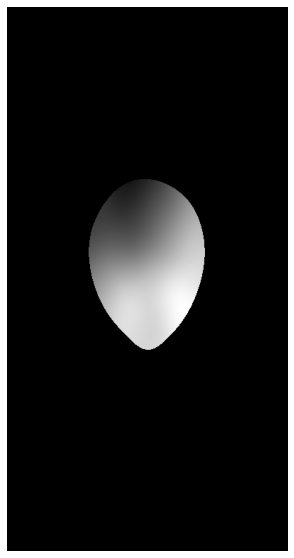

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(np.abs(sens_maps[0]),'gray')
ax.axis('off')